In [13]:
#Modified MM

#Importing the Required Libraries

#---import libraries regarding to data manipulation, visualization------------
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import json

# Imports Torch Libraries
import torch
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules

#Importing Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, multilabel_confusion_matrix, f1_score



#Data Loader
import pickle

import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import sys
sys.path.append('../../src/')  

#### Import Data Loading and Processing Functions
from multimodal.helper_functions import  reproducible_comp, get_final_df, force_curve_reshape, acc_curves_reshape

#### Import Model Architecture
from multimodal.model_architecture import MultimodalModel

from semi_supervised.augmentations import weak_augment, strong_augment

reproducible_comp()


In [2]:
file_path = "../../data/processed_data/force_outer.pkl"
with open(file_path, 'rb') as picklefile:
    data = pickle.load(picklefile)

features_force_outer, category_force_outer, category_names, df_force_outer = get_final_df(data, is_acc_data=0, is_multilabel=1)

file_path = "../../data/processed_data/acc_outer.pkl"
with open(file_path, 'rb') as picklefile:
    data = pickle.load(picklefile)

features_acc_outer, category_acc_outer, category_names, df_acc_outer = get_final_df(data, is_acc_data=1, is_multilabel=1)

In [3]:
labels_force = category_force_outer.copy()
features_force = features_force_outer.copy()
feat_force = force_curve_reshape(features_force)
print("Force Features Shape: ", feat_force.shape)
print("Force Labels Shape: ", labels_force.shape)

labels_acc = category_acc_outer.copy()
features_acc = features_acc_outer.copy()
feat_acc = acc_curves_reshape(features_acc)
print("Acceleration Features Shape: ", feat_acc.shape)
print("Acceleration Labels Shape: ", labels_acc.shape)

Force Features Shape:  (1330, 150)
Force Labels Shape:  (1330, 4)
Acceleration Features Shape:  (1330, 1500)
Acceleration Labels Shape:  (1330, 4)


In [4]:
X_train_force, X_test_force, y_train_force, y_test_force = train_test_split(feat_force, labels_force, test_size=0.1, 
                                                    random_state=2, shuffle=True, stratify=labels_force)

X_train_acc, X_test_acc, y_train_acc, y_test_acc = train_test_split(feat_acc, labels_acc, test_size=0.1, 
                                                    random_state=2, shuffle=True, stratify=labels_acc)                                                   

In [5]:
labeled_X_force, unlabeled_X_force, labeled_y_force, unlabeled_y_force = train_test_split(X_train_force, y_train_force, test_size=0.5, 
                                                    random_state=2, shuffle=True, stratify=y_train_force)

# Splitting Augmented Labeled Dataset into Train and Validation parts
X_labeled_force, x_val_force, y_labeled_force, y_val_force = train_test_split(labeled_X_force, labeled_y_force, random_state=42, test_size=0.20, shuffle=True)


X_labeled_force = X_labeled_force.reshape(-1, 1, feat_force.shape[1])
X_test_force = X_test_force.reshape(-1, 1, feat_force.shape[1])
x_val_force = x_val_force.reshape(-1, 1, feat_force.shape[1])

# Print the shapes of the train and validation datasets for labeled data
print("X_labeled_force shape:", X_labeled_force.shape)
print("y_labeled_force shape:", y_labeled_force.shape)
print("x_val_force shape:", x_val_force.shape)
print("y_val_force shape:", y_val_force.shape)

X_unlabeled_force = unlabeled_X_force.reshape(-1, 1, feat_force.shape[1])
y_unlabeled_force = unlabeled_y_force.copy()

# Print the shapes of the train and validation datasets for labeled data
print("X_labeled_force shape:", X_unlabeled_force.shape)
print("y_labeled_force shape:", y_unlabeled_force.shape)

X_labeled_force shape: (478, 1, 150)
y_labeled_force shape: (478, 4)
x_val_force shape: (120, 1, 150)
y_val_force shape: (120, 4)
X_labeled_force shape: (599, 1, 150)
y_labeled_force shape: (599, 4)


In [6]:
labeled_X_acc, unlabeled_X_acc, labeled_y_acc, unlabeled_y_acc = train_test_split(X_train_acc, y_train_acc, test_size=0.5, 
                                                    random_state=2, shuffle=True, stratify=y_train_acc)

# Splitting Augmented Labeled Dataset into Train and Validation parts
X_labeled_acc, x_val_acc, y_labeled_acc, y_val_acc = train_test_split(labeled_X_acc, labeled_y_acc, random_state=42, 
                                                                      test_size=0.20, shuffle=True)


X_labeled_acc = X_labeled_acc.reshape(-1, 1, feat_acc.shape[1])
X_test_acc = X_test_acc.reshape(-1, 1, feat_acc.shape[1])
x_val_acc = x_val_acc.reshape(-1, 1, feat_acc.shape[1])

# Print the shapes of the train and validation datasets for labeled data
print("X_labeled_acc shape:", X_labeled_acc.shape)
print("y_labeled_acc shape:", y_labeled_acc.shape)
print("x_val_acc shape:", x_val_acc.shape)
print("y_val_acc shape:", y_val_acc.shape)

X_unlabeled_acc = unlabeled_X_acc.reshape(-1, 1, feat_acc.shape[1])
y_unlabeled_acc = unlabeled_y_acc.copy()

# Print the shapes of the train and validation datasets for labeled data
print("X_labeled_acc shape:", X_unlabeled_acc.shape)
print("y_labeled_acc shape:", y_unlabeled_acc.shape)

X_labeled_acc shape: (478, 1, 1500)
y_labeled_acc shape: (478, 4)
x_val_acc shape: (120, 1, 1500)
y_val_acc shape: (120, 4)
X_labeled_acc shape: (599, 1, 1500)
y_labeled_acc shape: (599, 4)


In [7]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64

# Labeled Data Loader
train_dataset_force = TensorDataset(torch.tensor(X_labeled_force, dtype=torch.float), 
                              torch.tensor(y_labeled_force, dtype=torch.long))

labeled_dataloader_force = DataLoader(train_dataset_force, batch_size=batch_size, shuffle=True)

# Validation Data loader

valid_dataset_force = TensorDataset(torch.tensor(x_val_force, dtype=torch.float), 
                              torch.tensor(y_val_force, dtype=torch.long))

valid_dataloader_force = DataLoader(valid_dataset_force,batch_size=batch_size, shuffle=True)

# Strong Unlabeled Data Loader

unlabeled_dataset_force = TensorDataset(torch.tensor(X_unlabeled_force, dtype=torch.float), 
                                  torch.tensor(y_unlabeled_force, dtype=torch.long))
Unlabeled_dataloader_force= DataLoader(unlabeled_dataset_force, batch_size=batch_size, shuffle=True)  


In [8]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64

# Labeled Data Loader
train_dataset_acc = TensorDataset(torch.tensor(X_labeled_acc, dtype=torch.float), 
                              torch.tensor(y_labeled_acc, dtype=torch.long))

labeled_dataloader_acc = DataLoader(train_dataset_acc, batch_size=batch_size, shuffle=True)

# Validation Data loader

valid_dataset_acc = TensorDataset(torch.tensor(x_val_acc, dtype=torch.float), 
                              torch.tensor(y_val_acc, dtype=torch.long))

valid_dataloader_acc = DataLoader(valid_dataset_acc,batch_size=batch_size, shuffle=True)

# Strong Unlabeled Data Loader

unlabeled_dataset_acc = TensorDataset(torch.tensor(X_unlabeled_acc, dtype=torch.float), 
                                  torch.tensor(y_unlabeled_acc, dtype=torch.long))
Unlabeled_dataloader_acc= DataLoader(unlabeled_dataset_acc, batch_size=batch_size, shuffle=True)  


In [9]:
# Specify the path where you want to save the JSON file
config_file_path = "../../02_Optuna_Runs/multimodal/best_configs/multimodal_outer_best_configs.json"

# Load the saved configuration
with open(config_file_path, "r") as config_file:
    best_configs = json.load(config_file)

best_params = best_configs["best_params"]

input_channels = 1
num_classes = 4
force_n_layers = best_params["force_n_layers"]
force_kernel_size = best_params["force_kernel_size"]
force_stride = best_params["force_stride"]
force_padding = best_params["force_padding"]
force_hidden_channels = best_params["force_hidden_channels"]
force_pooling_type = best_params["force_pooling_type"]
force_use_batch_norm = best_params["force_use_batch_norm"]
acc_n_layers = best_params["acc_n_layers"]
acc_kernel_size = best_params["acc_kernel_size"]
acc_stride = best_params["acc_stride"]
acc_padding = best_params["acc_padding"]
acc_hidden_channels = best_params["acc_hidden_channels"]
acc_pooling_type = best_params["force_stride"]
acc_use_batch_norm = best_params["acc_use_batch_norm"]
dropout_prob = best_params["dropout_prob"]
lr = best_params["lr"]

best_params_json = json.dumps(best_params, indent=4)
print(best_params_json)

{
    "lr": 0.0005452723485761036,
    "dropout_prob": 0.42333881966763554,
    "force_n_layers": 2,
    "force_kernel_size": 3,
    "force_stride": 5,
    "force_padding": 4,
    "force_hidden_channels": 65,
    "force_pooling_type": "max",
    "force_use_batch_norm": true,
    "acc_n_layers": 4,
    "acc_kernel_size": 6,
    "acc_stride": 2,
    "acc_padding": 5,
    "acc_hidden_channels": 33,
    "acc_pooling_type": "max",
    "acc_use_batch_norm": false
}


In [33]:
def multi_label_accuracy(y_true, y_pred):
    # Check if each label is correctly predicted
    label_accuracies = np.mean(y_true == y_pred, axis=0)
    # Compute the overall accuracy by taking the mean of label accuracies
    accuracy = np.mean(label_accuracies)
    return accuracy

# Define your loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = MultimodalModel(input_channels, num_classes, 
                force_n_layers, force_kernel_size, force_stride, force_padding, force_hidden_channels,
                force_pooling_type, force_use_batch_norm,
                acc_n_layers, acc_kernel_size, acc_stride, acc_padding, acc_hidden_channels,
                acc_pooling_type, acc_use_batch_norm, dropout_prob).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])

confidence_threshold = 0.95

training_losses = []
validation_losses = []
supervised_losses = []
unsupervised_losses = []

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_supervised_loss = 0.0
    total_unsupervised_loss = 0.0

    # Supervised training on labeled data
    for (inputs_acc, labels), (inputs_force,lab) in zip(labeled_dataloader_acc, labeled_dataloader_force):

        inputs_acc, labels, inputs_force = inputs_acc.to(device), labels.to(device), inputs_force.to(device)

        optimizer.zero_grad()

        # Forward pass through the multimodal model
        outputs = model(inputs_force,inputs_acc)

        loss = criterion(outputs, labels.float())

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        total_supervised_loss += loss.item()
    
    # Semi-supervised training on unlabeled data
    for (inputs_unlabeled_acc, labels_), (inputs_unlabeled_force,lab_) in zip(Unlabeled_dataloader_acc, Unlabeled_dataloader_force):

        inputs_unlabeled_acc = inputs_unlabeled_acc.to(device)
        inputs_unlabeled_force = inputs_unlabeled_force.to(device)

        
        # Apply weak augmentation on force
        batch_size_force = inputs_unlabeled_force.shape[0]

        inputs_weak_force = weak_augment(inputs_unlabeled_force, batch_size_force).float().to(device)
        
        # Apply weak augmentation on acc
        batch_size_acc = inputs_unlabeled_acc.shape[0]

        inputs_weak_acc = weak_augment(inputs_unlabeled_acc, batch_size_acc).float().to(device)        

        # Generate pseudo-labels
        with torch.no_grad():
        
            outputs_weak = model(inputs_weak_force,inputs_weak_acc)

            pseudo_probs = torch.softmax(outputs_weak, dim=1)

            max_probs, pseudo_label_indices = torch.max(pseudo_probs, dim=1)

            mask = max_probs.ge(confidence_threshold) 

        # Apply one-hot encoding to the pseudo-label indices
        pseudo_labels_one_hot = torch.nn.functional.one_hot(pseudo_label_indices, num_classes=num_classes)

        pseudo_labels_one_hot = pseudo_labels_one_hot.to(torch.float32)  


        # Apply strong augmentation on force
        inputs_strong_force = strong_augment(inputs_unlabeled_force, batch_size_force).float().to(device)

        # Apply strong augmentation on force
        inputs_strong_acc = strong_augment(inputs_unlabeled_acc, batch_size_acc).float().to(device)

        # Calculate unsupervised loss
        optimizer.zero_grad()
        outputs_strong = model(inputs_strong_force,inputs_strong_acc)

        unsupervised_loss = criterion(outputs_strong, pseudo_labels_one_hot)

        unsupervised_loss = torch.mean(unsupervised_loss * mask.float())
        unsupervised_loss.backward()
        optimizer.step()

        running_loss += unsupervised_loss.item()
        total_unsupervised_loss += unsupervised_loss.item()

    # Validation and logging
    model.eval()
    # Validation loss calculation (similar to training loop)
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for (inputs_acc_valid, labels_valid), (inputs_force_valid,lab) in zip(valid_dataloader_acc, valid_dataloader_force):

            inputs_acc_valid, labels_valid, inputs_force_valid = inputs_acc_valid.to(device), labels_valid.to(device), inputs_force_valid.to(device)
            outputs_valid = model(inputs_force_valid, inputs_acc_valid)
            loss_valid = criterion(outputs_valid, labels_valid.float())
            valid_loss += loss_valid.item()
    
    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {running_loss / (len(labeled_dataloader_force) + len(Unlabeled_dataloader_force))}, Supervised Loss: {total_supervised_loss / len(labeled_dataloader_force)}, Unsupervised Loss: {total_unsupervised_loss / len(Unlabeled_dataloader_force)}, Validation Loss: {valid_loss / len(valid_dataloader_force)}")
    # Inside your training loop, after calculating the losses
    training_losses.append(running_loss / (len(labeled_dataloader_force) + len(Unlabeled_dataloader_force)))
    validation_losses.append(valid_loss / len(valid_dataloader_force))
    supervised_losses.append(total_supervised_loss / len(labeled_dataloader_force))
    unsupervised_losses.append(total_unsupervised_loss / len(Unlabeled_dataloader_force))



# Evaluation of Accuracy
model.eval()
y_true_valid = []
y_pred_valid = []

with torch.no_grad():
    for (inputs_acc_valid, labels_valid), (inputs_force_valid,lab) in zip(valid_dataloader_acc, valid_dataloader_force):
        inputs_acc_valid, labels_valid, inputs_force_valid = inputs_acc_valid.to(device), labels_valid.to(device), inputs_force_valid.to(device)
        labels_valid = labels_valid.int()
        outputs_valid = model(inputs_force_valid, inputs_acc_valid)
        predicted = (outputs_valid > 0).int()
        y_true_valid.append(labels_valid.cpu().numpy())
        y_pred_valid.append(predicted.cpu().numpy())

# Convert lists to NumPy arrays for calculations
y_true_valid = np.array(y_true_valid[0]).reshape(-1,4)
y_pred_valid = np.array(y_pred_valid[0]).reshape(-1,4)

accuracy = multi_label_accuracy(y_true_valid, y_pred_valid)
print(f"Multi-label Validation Accuracy: {accuracy * 100:.2f}%")

Epoch 1/50, Training Loss: 0.30733686685562134, Supervised Loss: 0.691507950425148, Unsupervised Loss: 0.0, Validation Loss: 0.686669796705246
Epoch 2/50, Training Loss: 0.3004579212930467, Supervised Loss: 0.6760303229093552, Unsupervised Loss: 0.0, Validation Loss: 0.6680535078048706
Epoch 3/50, Training Loss: 0.2913187841574351, Supervised Loss: 0.655467264354229, Unsupervised Loss: 0.0, Validation Loss: 0.6390969157218933
Epoch 4/50, Training Loss: 0.282934351099862, Supervised Loss: 0.6366022899746895, Unsupervised Loss: 0.0, Validation Loss: 0.6364428102970123
Epoch 5/50, Training Loss: 0.28130916092130875, Supervised Loss: 0.6329456120729446, Unsupervised Loss: 0.0, Validation Loss: 0.6344756484031677
Epoch 6/50, Training Loss: 0.27862294183837044, Supervised Loss: 0.6269016191363335, Unsupervised Loss: 0.0, Validation Loss: 0.6284588277339935
Epoch 7/50, Training Loss: 0.27764736943774754, Supervised Loss: 0.624706581234932, Unsupervised Loss: 0.0, Validation Loss: 0.6095896363

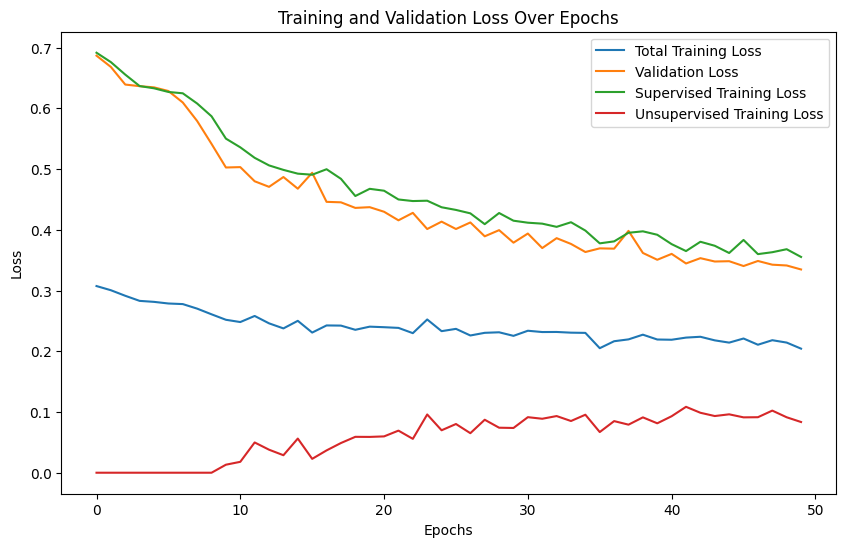

In [38]:
# After training, plot the losses
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Total Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.plot(supervised_losses, label='Supervised Training Loss')
plt.plot(unsupervised_losses, label='Unsupervised Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [39]:
torch.save(model, '../../artifacts/multimodal_outer_FM.pth')

# Evaluation on test set


In [11]:
model = torch.load('../../artifacts/multimodal_outer_FM.pth')


Multi-label Accuracy: 84.77%
Multi-label F1-Score: 75.08%
Classification Report:
               precision    recall  f1-score   support

        Dünn       0.75      0.92      0.82        51
    Referenz       0.86      0.93      0.89        27
        Slug       1.00      0.27      0.43        55
        Worn       0.83      0.88      0.86        51

   micro avg       0.82      0.72      0.77       184
   macro avg       0.86      0.75      0.75       184
weighted avg       0.86      0.72      0.73       184
 samples avg       0.82      0.76      0.76       184



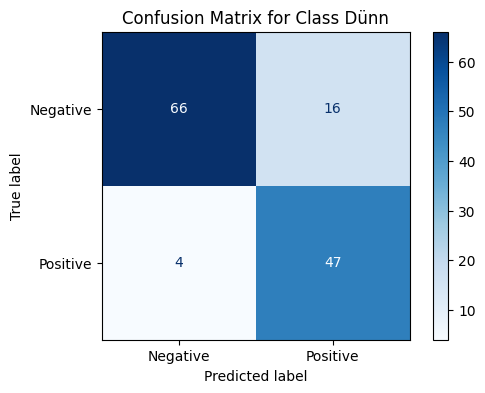

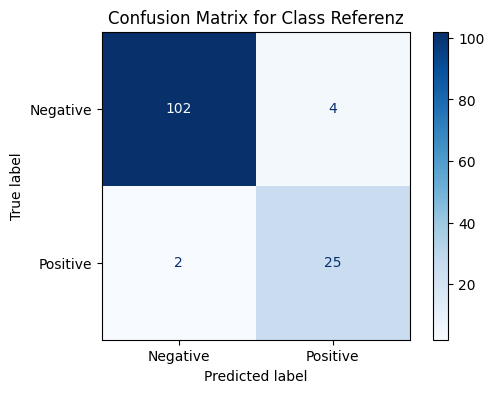

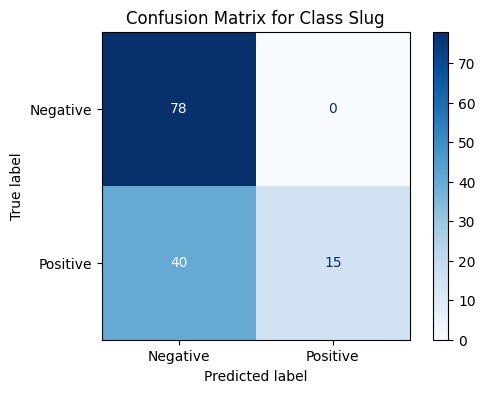

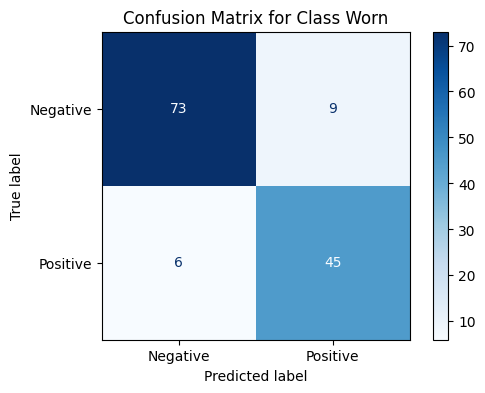

In [14]:
# Evaluation on test set
def multi_label_accuracy(y_true, y_pred):
    # Check if each label is correctly predicted
    label_accuracies = np.mean(y_true == y_pred, axis=0)
    # Compute the overall accuracy by taking the mean of label accuracies
    accuracy = np.mean(label_accuracies)
    return accuracy

model.eval()
y_true_test = []
y_pred_test = []

X_test_acc = torch.tensor(X_test_acc, dtype=torch.float32)
X_test_force = torch.tensor(X_test_force, dtype=torch.float32)
y_test_force = torch.tensor(y_test_force, dtype=torch.long)

with torch.no_grad():
    for inputs_force_test, inputs_acc_test, labels_test in zip(X_test_force,X_test_acc, y_test_force):
        inputs_force_test, inputs_acc_test, labels_test = inputs_force_test.to(device), inputs_acc_test.to(device), labels_test.to(device)
        
        labels_test = labels_test.int()
        
        outputs = model(inputs_force_test.unsqueeze(0), inputs_acc_test.unsqueeze(0)) 
        predicted = (outputs > 0).int() 
        
        y_true_test.append(labels_test.cpu().numpy())
        y_pred_test.append(predicted.cpu().numpy())

# Convert lists to NumPy arrays for calculations
y_true_test = np.array(y_true_test).reshape(-1,4)
y_pred_test = np.array(y_pred_test).reshape(-1,4)


accuracy = multi_label_accuracy(y_true_test, y_pred_test)
print(f"Multi-label Accuracy: {accuracy * 100:.2f}%")

f1 = f1_score(y_true_test, y_pred_test, average='macro')
print(f"Multi-label F1-Score: {f1 * 100:.2f}%")

# Generate a classification report
report = classification_report(y_true_test, y_pred_test, target_names=category_names)
print("Classification Report:\n", report)

# Compute the multi-label confusion matrix
conf_matrix = multilabel_confusion_matrix(y_true_test, y_pred_test)

# Visualize each confusion matrix with sample counts
for i, matrix in enumerate(conf_matrix):
    total_samples = matrix.sum()
    
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["Negative", "Positive"])
    fig, ax = plt.subplots(figsize=(6, 4))
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='.0f')
    ax.set_title(f'Confusion Matrix for Class {category_names[i]}')
    
    plt.show()

# Thank You